### Purchased Collar Strategies

In this <a href="https://www.python.org/doc/essays/blurb/">Python</a> notebook, we will dive into options hedging strategies named as collars strategies.  

This hedging strategy uses a combination of protective strategy and selling options to collar the value of an asset position within a specific range. 

By using a protective strategy, the investor can insure their asset position (long or short) whilst reducing the cost of insurance by selling an option.

- In a **purchased collar**, the strategy consists of a protective put and selling a call option.
- In a **written collar**, the strategy consists of a protective call and selling a put option.


To do so, we have to generate multiple scenarios of the underlying asset since its evolution is completely random . To generate such underlying monte_carlo simulations, we will use practical functions of the <a href="https://finance.math.upmc.fr/en/enseignements/1_2_probas_numeriques/">Numerical Probability</a> course from the master's degree <a href="https://finance.math.upmc.fr/en/">M2 Probabilités et Finance</a> taught by both <a href="https://www.lpsm.paris/users/pages/index">Gilles Pagès</a> and <a href="https://perso.lpsm.paris/~vlemaire/site.html">Vincent Lemaire</a> . With their practical hands-on notebooks, we can easily see and plot various scenarios of underlying asset . 

Hence, we then run a notebook called `Monte_Carlo_Simulation.ipynb` where we can find all these functions . We will not provide these functions directly but you can easily implement them to well understand what's going on behind the scenes.

In [1]:
%run Monte_Carlo_Simulation.ipynb  # we run this notebook Monte_Carlo_Simulation 

We then provide all the necessary parameters the function `black_scholes_1d` which displays all the underlying asset scenarios. Here is the <a href="https://www.geeksforgeeks.org/python-docstrings/">docstring</a> of the function : 

The Black and Scholes Process is defined by the following <a href="https://ethz.ch/content/dam/ethz/special-interest/mavt/dynamic-systems-n-control/idsc-dam/Lectures/Stochastic-Systems/SDE.pdf">Stochastic Differential Equation</a>

Let $S_t$ be the solution of the SDE on $[0,T]$
$$
    \operatorname{d}\!S_t = r S_t \operatorname{d}\!t + \sigma S_t \operatorname{d}\!B_t, \quad S_0 = x
$$
Then $S_t$ is given by : 
$$
    S_t = x \exp \bigl((r- \sigma^2/2) t + \sigma B_t \bigr)
$$


`black_scholes_1d` : Simulate paths of Black-Scholes process
-    Args:
       - n_times: Number of timesteps
       - n_paths: Number of paths 
       - final_time: Final time of simulation
       - init_value: `S0`
       - r: Interest rate
       - sigma: Volatility
       - random_state: `np.random.Generator` used for simulation
-    Returns:
       - `np.array` of shape `(n_times+1, n_paths)` containing the paths 
       
We then define the function parameters and plot our results to see what happens . 

In [2]:
N = 5 
M = 500
S0 = 100
r, sigma = 0.1, 0.2
D = 0 
T = 1 
K_1 = 90
K_2 = 120
St = black_scholes_1d(N, M, init_value=S0, r=r, sigma=sigma) # Paths of BS Process

In [3]:
St[:10] # display the first 10 element of the underlying asset array 

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [118.61968781, 103.28863841,  99.1350878 , ..., 113.26021001,
        122.04240126,  83.40318568],
       [125.12336507, 108.94029187,  95.97805911, ..., 125.45681267,
        132.73206094,  86.2711667 ],
       [120.14471164,  97.8362555 ,  97.39647201, ..., 129.32034125,
        145.68212903,  86.71694454],
       [100.5870618 ,  90.55839619, 101.12682056, ..., 112.66173718,
        154.309557  ,  90.68845513],
       [ 76.53909196,  96.37068642, 106.32972736, ..., 103.09390244,
        147.66280455, 108.52390847]])

In [4]:
import seaborn as sns
sns.set_theme()

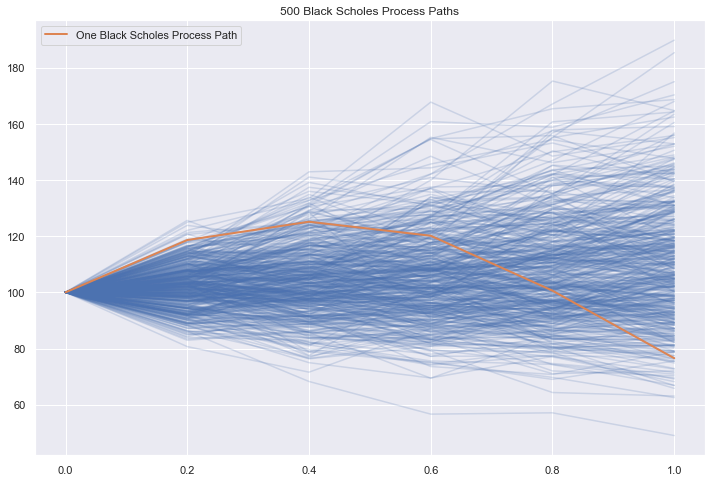

In [5]:
plt.figure(figsize=(12,8))
times = np.arange(N+1)*(T / N)
for S in St.T:
    sns.lineplot(x=times, y=S, color='C0', alpha=0.2)
ax = sns.lineplot(x=times, y=St[:,0], color='C1', lw=2, label='One Black Scholes Process Path')
ax.set(title=f"{M} Black Scholes Process Paths");

We can see in the preceding graph, 500 simulations of Black and Scholes Process. 

The next step is to store the last maturity time values of the BS process that is : Values of $S_t$ for which $t=T$ which is $1$ in our case . Why ? Because, we want to represent the <a href="https://www.math.fsu.edu/~paris/FMexam/DM%20Module%201.pdf">Payoff</a> of covered options strats and because the payoff is generally computed at the maturity for <a href="https://www.schwab.com/options/what-is-trading-options">options</a> .

In [6]:
stock_prices = St.T[:,-1]  # We store the last values at the maturity T of our stock_prices vector

We then <a href="https://www.geeksforgeeks.org/introduction-to-sorting-algorithm/">sort</a> our stock_prices vector in order to well represent the payoff since our simulations are purely random. To sort our vector, we used <a href="https://numpy.org/doc/stable/reference/generated/numpy.sort.html">`np.sort`</a> which has <a href="https://blog.finxter.com/how-to-sort-in-one-line/#:~:text=The%20runtime%20complexity%20of%20the,log(n))%20on%20average.">nlog(n)</a> complexity which the most efficient algorithm to sort tables in modern programming languages .

In [7]:
stock_prices = np.sort(stock_prices) # sort our stock_prices 

### Purchased Collar Strategy

$\textit{Purchased Collar}$ : A purchased collar is a hedging strategy whereby at time $t$ an investor
buys an asset $S_t$, buys a put option $P(S_t, t; K_1, T)$ with strike price $K_1$ and sells a call option
$C(S_t, t; K_2, T)$ with strike price $K_2$, $K_1 < K_2$ on the same underlying $S_t$ and having the
same expiry time $T(T>t)$.

The value of the strategy at time $t$ is given by :
$$
\Pi_t = S_t + P(S_t,t;K_1,T) - C(S_t, t; K_2, T)
$$



The payoff of this strategy a $T$ is : 

$$
\Psi(S_T) = S_T + P(S_T,T;K_1,T) - C(S_T,T;K_2,T)= 
\begin{cases} 
K_1 & \text{if } S_T \leq K_1 \\
S_T & \text{if } K_1 < S_T \leq K_2 \\
K_2 & \text{if } S_T > K_2
\end{cases}
$$

The profit of this strategy is given by :

$$
\Gamma(S_T) = \Psi(S_T) - \Pi_t= S_T + P(S_T,T;K_1,T) - C(S_T,T;K_2,T) - S_t - P(S_t, t; K_1, T) + C(S_t, t; K_2, T)= 
\begin{cases} 
K_1 + C(S_t, t; K_2, T) - P(S_t, t; K_1, T) - S_t & \text{if } S_T \leq K_1, \\
S_T + C(S_t, t; K_2, T) - P(S_t, t; K_1, T) - S_t & \text{if } K_1 < S_T \leq K_2 \\
K_2 + C(S_t, t; K_2, T) - P(S_t, t; K_1, T) - S_t & \text{if } S_T > K_2
\end{cases}
$$

Before plotting the Profit diagram of the purchased collar strategy, we have to compute the option premium . Thanks to our `EuropeanOptions` class we implemented in previous notebook you can find on my github <a href="https://github.com/Ncxs99/Financial-Mathematics/blob/master/Equity%20Derivatives%20Pricing/European%20Options/Europea_Options.ipynb">Ncxs99</a> . We then use our class to directly find the premiums of the corresponding options .

In [8]:
premium_put = EuropeanOptions(S0,K_1,T,sigma,r,D)
premium_put = premium_put.Put_Black_Scholes()
premium_put

1.423944748631829

In [9]:
premium_call = EuropeanOptions(S0,K_2,T,sigma,r,D)
premium_call = premium_call.Call_Black_Scholes()
premium_call

4.708214272370071

After compute the option prices , then here is how we proceed to display the payoff and the profit of the purchased collar strategy : 

- compute `purchased_collar_put_k_1_payoff` : maximum(`K_1` - `stock_prices`, 0)

- compute `purchased_collar_call_k_2_payoff` : maximum(`stock_prices` - `K_2`, 0)

- compute `purchased_collar_payoff` : `stock_prices` + `purchased_collar_put_k_1_payoff` - `purchased_collar_k_2_payoff`

- Compute `stock_profits` which is in fact the profit the investor can make only the stock options .  
`stock_profit` = `stock_prices` - `S0` 

- Compute the `purchased_collar_put_k_1_profit` which is in fact the profit earn only on the put option . `purchased_collar_put_k_1_profit` = `purchased_collar_put_k_1_payoff` - `premium_put`

- Compute the `purchased_collar_call_k_2_profit` which is in fact the profit earn only on the call option . `purchased_collar_call_k_2_profit` = -`purchased_collar_call_k_2_payoff` + `premium_call`

In [10]:
purchased_collar_put_k_1_payoff = np.maximum(K_1 - stock_prices, 0)
purchased_collar_call_k_2_payoff = np.maximum(stock_prices - K_2 , 0)
purchased_collar_payoff = stock_prices + purchased_collar_put_k_1_payoff - purchased_collar_call_k_2_payoff

In [11]:
stock_profits = stock_prices - S0
purchased_collar_put_k_1_profit = purchased_collar_put_k_1_payoff - premium_put
purchased_collar_call_k_2_profit = - purchased_collar_call_k_2_payoff + premium_call
purchased_collar_profit = stock_profits + purchased_collar_put_k_1_profit + purchased_collar_call_k_2_profit

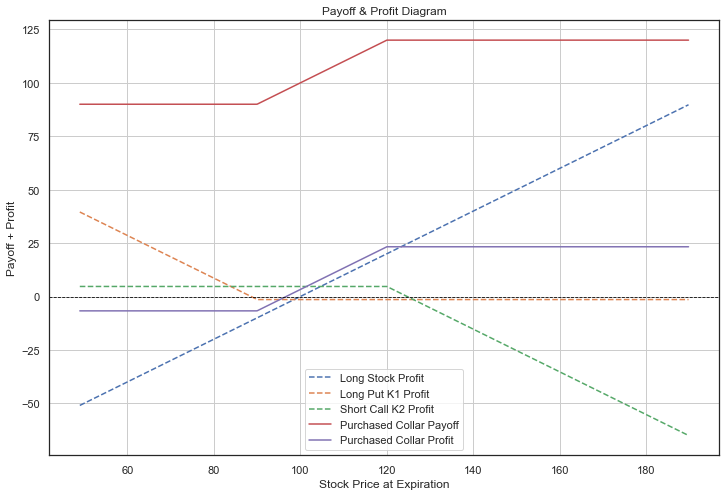

In [12]:
sns.set_theme(style='white')
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, stock_profits, label="Long Stock Profit", linestyle='--')
plt.plot(stock_prices, purchased_collar_put_k_1_profit, label="Long Put K1 Profit", linestyle='--')
plt.plot(stock_prices, purchased_collar_call_k_2_profit, label="Short Call K2 Profit", linestyle='--')
plt.plot(stock_prices, purchased_collar_payoff, label="Purchased Collar Payoff")
plt.plot(stock_prices, purchased_collar_profit, label="Purchased Collar Profit")
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")
plt.title("Payoff & Profit Diagram")
plt.xlabel("Stock Price at Expiration")
plt.ylabel("Payoff + Profit")
plt.legend()
plt.grid()
plt.show()

### Purchased Collar Greeks

We will review the purchased collar greeks . In fact, we the purchased collar greeks are similar to the call spread ones since they have almost the same shape .

In [13]:
delta_put_k_1 = EuropeanOptions(stock_prices, K_1, T, sigma, r, D)
delta_put_k_1 = delta_put_k_1.Delta_Put()


delta_call_k_2 = EuropeanOptions(stock_prices, K_2, T, sigma, r, D)
delta_call_k_2 = delta_call_k_2.Delta_Call()


delta_purchased_collar = 1 + delta_put_k_1 - delta_call_k_2

In [14]:
gamma_put_k_1 = EuropeanOptions(stock_prices, K_1, T, sigma, r, D)
gamma_put_k_1 = gamma_put_k_1.Gamma_Put()


gamma_call_k_2 = EuropeanOptions(stock_prices, K_2, T, sigma, r, D)
gamma_call_k_2 = gamma_call_k_2.Gamma_Call()


gamma_purchased_collar = gamma_put_k_1 - gamma_call_k_2

In [15]:
vega_put_k_1 = EuropeanOptions(stock_prices, K_1, T, sigma, r, D)
vega_put_k_1 = vega_put_k_1.Vega_Put()


vega_call_k_2 = EuropeanOptions(stock_prices, K_2, T, sigma, r, D)
vega_call_k_2 = vega_call_k_2.Vega_Call()


vega_purchased_collar = vega_put_k_1 - vega_call_k_2

In [16]:
theta_put_k_1 = EuropeanOptions(stock_prices, K_1, T, sigma, r, D)
theta_put_k_1 = theta_put_k_1.Theta_Put()


theta_call_k_2 = EuropeanOptions(stock_prices, K_2, T, sigma, r, D)
theta_call_k_2 = theta_call_k_2.Theta_Call()


theta_purchased_collar = theta_put_k_1 - theta_call_k_2

We then plot the purchased collar greeks

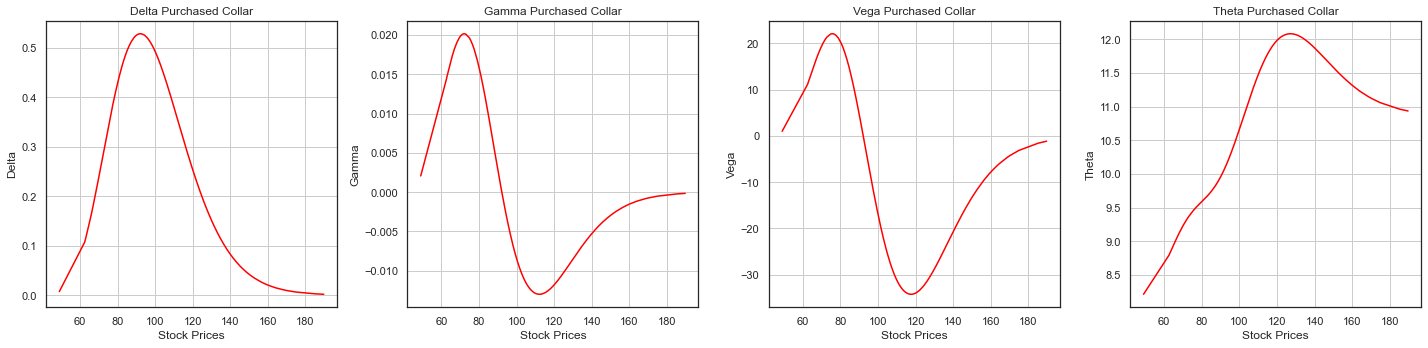

In [17]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

# Delta Purchased Collar
axes[0].plot(stock_prices, delta_purchased_collar, c='red')
axes[0].set_title('Delta Purchased Collar')
axes[0].set_xlabel('Stock Prices')
axes[0].set_ylabel('Delta')
axes[0].grid()

# Gamma Purchased Collar
axes[1].plot(stock_prices, gamma_purchased_collar, c='red')
axes[1].set_title('Gamma Purchased Collar')
axes[1].set_xlabel('Stock Prices')
axes[1].set_ylabel('Gamma')
axes[1].grid()

# Vega Purchased Collar
axes[2].plot(stock_prices, vega_purchased_collar, c='red')
axes[2].set_title('Vega Purchased Collar')
axes[2].set_xlabel('Stock Prices')
axes[2].set_ylabel('Vega')
axes[2].grid()

# Theta Purchased Collar
axes[3].plot(stock_prices, theta_purchased_collar, c='red')
axes[3].set_title('Theta Purchased Collar')
axes[3].set_xlabel('Stock Prices')
axes[3].set_ylabel('Theta')
axes[3].grid()

# Adjust layout
plt.tight_layout()
plt.show()